In [1]:
import sys, os

project_root = os.path.abspath(os.path.join(".."))  
src_path     = os.path.join(project_root, "src")
sys.path.insert(0, src_path)

Imports and utility functions

In [2]:
import torch
import numpy as np

from data import sample_interior, sample_initial, sample_boundary, u0
from model import PINN
from loss import total_loss
from validation import fd_burgers_lax_friedrichs, compute_l2_errors
from visualize import plot_losses, plot_heatmaps

Hyperparameters

In [3]:
nu        = 1e-2
T         = 1.0
N_f, N0, N_b = 10000, 200, 200

epochs     = 10000
lr         = 1e-3
print_every= 1000

Device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Model, optimizer, and Scheduler

In [5]:
model     = PINN(layers=[2,50,50,50,1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                           step_size=5000,
                                           gamma=0.5)

Pre-sample IC and BC (fixed throughout training)

In [6]:
X0_np,    u0_np    = sample_initial(N0)           # (N0,2), (N0,1)
(Xb0_np, g0_np), (Xb1_np, g1_np) = sample_boundary(N_b, T)

# to torch tensors
X0    = torch.from_numpy(X0_np).float().to(device)
u0_v  = torch.from_numpy( u0_np).float().to(device)
Xb0   = torch.from_numpy(Xb0_np).float().to(device)
Xb1   = torch.from_numpy(Xb1_np).float().to(device)
g0_v  = torch.from_numpy( g0_np).float().to(device)
g1_v  = torch.from_numpy( g1_np).float().to(device)

Training Loop

In [7]:
history = {
    'total': [],
    'L_f':   [],
    'L_0':   [],
    'L_b':   []
}

for epoch in range(1, epochs+1):
    # Resample interior collocation points
    Xf_np = sample_interior(N_f, T)                # (N_f,2)
    Xf     = torch.from_numpy(Xf_np).float().to(device)
    
    # Compute total loss + components
    optimizer.zero_grad()
    L, comps = total_loss(
        model,
        Xf,          # collocation
        X0, u0_v,    # initial
        Xb0, Xb1, g0_v, g1_v,  # boundary
        nu,
        lambda0=1.0,
        lambda_b=1.0
    )
    
    # Backprop & optimizer step
    L.backward()
    optimizer.step()
    scheduler.step()

    # Append to history
    history['total'].append(L.item())
    history['L_f'].append(comps['L_f'].item())
    history['L_0'].append(comps['L_0'].item())
    history['L_b'].append(comps['L_b'].item())
    
    # Logging
    if epoch % print_every == 0 or epoch == 1:
        print(f"Epoch {epoch:5d} | "
              f"L_f={comps['L_f']:.2e}  "
              f"L_0={comps['L_0']:.2e}  "
              f"L_b={comps['L_b']:.2e}  "
              f"Total={L:.2e}  "
              f"LR={scheduler.get_last_lr()[0]:.1e}")

Epoch     1 | L_f=3.73e-03  L_0=3.09e-01  L_b=1.17e-01  Total=4.30e-01  LR=1.0e-03
Epoch  1000 | L_f=2.68e-02  L_0=3.19e-02  L_b=7.99e-03  Total=6.66e-02  LR=1.0e-03
Epoch  2000 | L_f=1.02e-02  L_0=1.66e-02  L_b=1.13e-03  Total=2.79e-02  LR=1.0e-03
Epoch  3000 | L_f=3.04e-03  L_0=3.20e-03  L_b=5.05e-04  Total=6.74e-03  LR=1.0e-03
Epoch  4000 | L_f=1.38e-03  L_0=9.18e-04  L_b=2.56e-04  Total=2.55e-03  LR=1.0e-03
Epoch  5000 | L_f=7.88e-04  L_0=5.22e-04  L_b=2.28e-04  Total=1.54e-03  LR=5.0e-04
Epoch  6000 | L_f=6.15e-04  L_0=3.89e-04  L_b=1.84e-04  Total=1.19e-03  LR=5.0e-04
Epoch  7000 | L_f=8.04e-04  L_0=3.13e-04  L_b=1.38e-04  Total=1.25e-03  LR=5.0e-04
Epoch  8000 | L_f=8.25e-04  L_0=2.43e-04  L_b=1.30e-04  Total=1.20e-03  LR=5.0e-04
Epoch  9000 | L_f=6.27e-04  L_0=1.87e-04  L_b=1.25e-04  Total=9.38e-04  LR=5.0e-04
Epoch 10000 | L_f=6.75e-04  L_0=1.42e-04  L_b=1.17e-04  Total=9.34e-04  LR=2.5e-04


Validation and Visualization

In [8]:
# Run classical solver
Nx, Nt = 256, 2000
x, us_map, ts_map = fd_burgers_lax_friedrichs(
    Nx=Nx, Nt=Nt, T=T, nu=nu, u0_fn=u0
)

# Sort saved slices by actual time
sorted_steps = sorted(ts_map.items(), key=lambda kv: kv[1]) # list of (step, t)
steps, t_vals = zip(*sorted_steps)

x_grid = x
t_grid = np.array(t_vals)
u_fd_grid = np.vstack([us_map[step] for step in steps])

# Compute PINN vs FD L2 errors
errors = compute_l2_errors(model, x, us_map, ts_map, device)

# Print results
for t, err in errors.items():
    print(f"t = {t:.3f}: L2 error = {err:.3e}")

t = 0.250: L2 error = nan
t = 0.500: L2 error = nan
t = 0.750: L2 error = nan
t = 1.000: L2 error = nan


c:\Users\sabme\CodingProjects\PINN-for-PDEs\src\validation.py:24: RuntimeWarning: overflow encountered in square
  f = u_prev**2 / 2.0
c:\Users\sabme\CodingProjects\PINN-for-PDEs\src\validation.py:28: RuntimeWarning: invalid value encountered in subtract
  - dt/(2*dx)*(f[2:] - f[:-2])
c:\Users\sabme\CodingProjects\PINN-for-PDEs\src\validation.py:27: RuntimeWarning: invalid value encountered in add
  0.5*(u_prev[2:] + u_prev[:-2])
c:\Users\sabme\CodingProjects\PINN-for-PDEs\src\validation.py:29: RuntimeWarning: invalid value encountered in add
  + nu*dt/(dx**2)*(u_prev[2:] - 2*u_prev[1:-1] + u_prev[:-2])


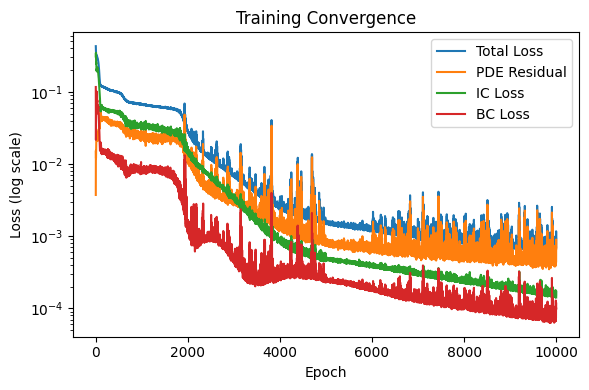

In [9]:
plot_losses(history)

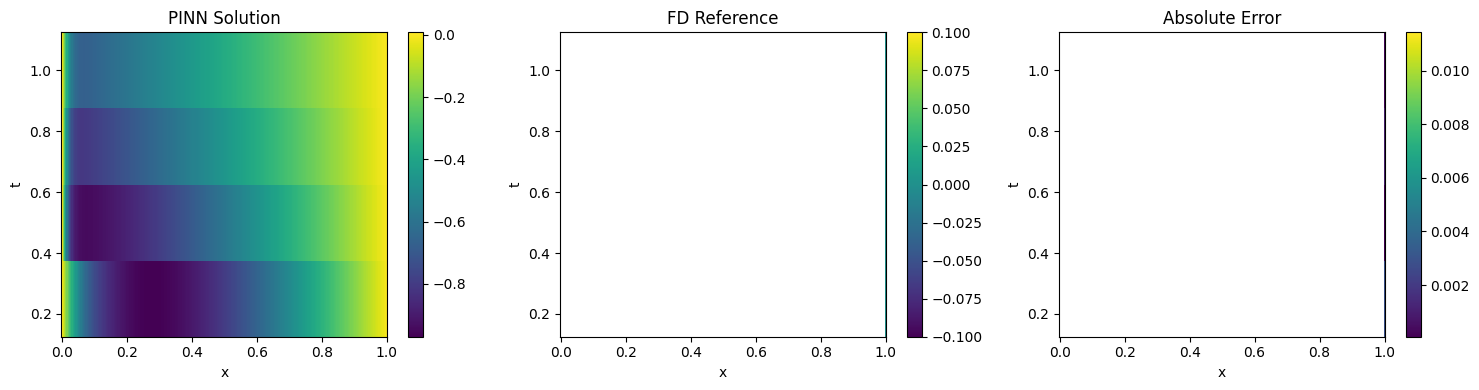

In [10]:
plot_heatmaps(model, x_grid, t_grid, u_fd_grid, device)